# Libraries

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [70]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import Imputer

In [71]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

In [72]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Exploratory Visualization

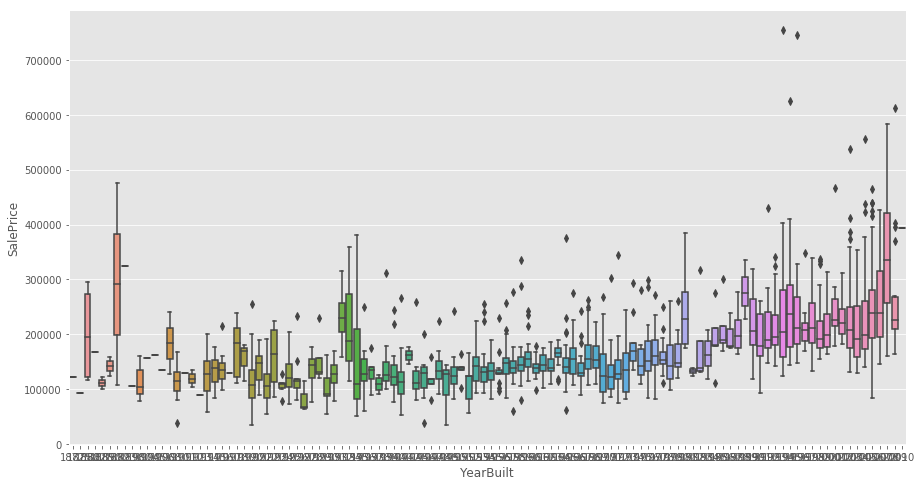

In [73]:
plt.figure(figsize=(15,8))
sns.boxplot(train.YearBuilt, train.SalePrice)

# Outlier

(0, 800000)

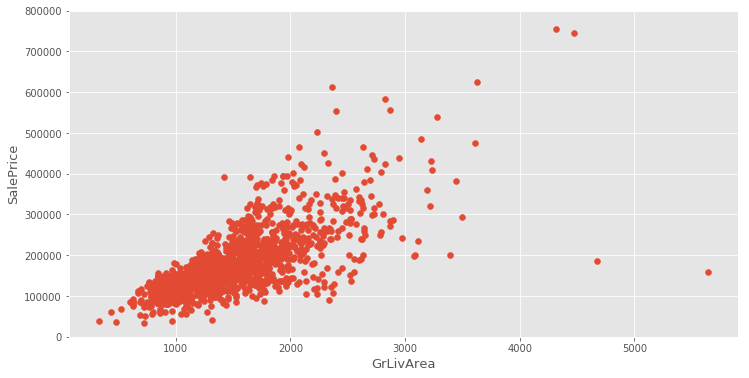

In [74]:
plt.figure(figsize=(12,6))
plt.scatter(x=train.GrLivArea, y=train.SalePrice)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

In [75]:
train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index,inplace=True)
full=pd.concat([train,test], ignore_index=True)
full.drop(['Id'],axis=1, inplace=True)
full.shape

(2917, 80)

# Data Cleaning

In [76]:
aa = full.isnull().sum()
aa[aa>0].sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64

In [77]:
full.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        46.900000   43.0    20
Blueste        27.300000   24.0    10
BrDale         21.500000   21.0    30
BrkSide        55.789474   51.0    95
ClearCr        88.150000   80.5    20
CollgCr        71.336364   70.0   220
Crawfor        69.951807   70.0    83
Edwards        65.153409   64.5   176
Gilbert        74.207207   64.0   111
IDOTRR         62.241379   60.0    87
MeadowV        25.606061   21.0    33
Mitchel        75.144444   74.0    90
NAmes          75.210667   73.0   375
NPkVill        28.142857   24.0    21
NWAmes         81.517647   80.0    85
NoRidge        91.629630   89.0    54
NridgHt        84.184049   92.0   163
OldTown        61.777293   60.0   229
SWISU          59.068182   60.0    44
Sawyer         74.551020   72.0    98
SawyerW        70.669811   67.0   106
Somerst        64.549383   72.5   162
StoneBr        62.173913   60.0    46
Timber         81.157895   82.0    57
Veenker        72.000000   80.0    16

In [78]:
full["LotAreaCut"] = pd.qcut(full.LotArea,10)
full.groupby(['LotAreaCut'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                           mean median count
LotAreaCut                                  
(1299.999, 4921.8]    35.741036   34.0   251
(4921.8, 7007.2]      55.460674   52.0   267
(7007.2, 7949.0]      62.959839   62.0   249
(7949.0, 8740.4]      67.113725   65.0   255
(8740.4, 9452.0]      69.959184   70.0   245
(9452.0, 10148.8]     73.988235   75.0   255
(10148.8, 11000.0]    73.636364   75.0   253
(11000.0, 12196.8]    83.371681   82.0   226
(12196.8, 14285.8]    84.973684   85.0   228
(14285.8, 215245.0]   92.846535   90.0   202

In [79]:
# Since some combinations of LotArea and Neighborhood are not available, so we just LotAreaCut alone.
full['LotFrontage']=full.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

cols=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    full[col].fillna(0, inplace=True)

cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    full[col].fillna("None", inplace=True)

# fill in with mode
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    full[col].fillna(full[col].mode()[0], inplace=True)

In [80]:
full.isnull().sum()[full.isnull().sum()>0]

SalePrice    1459
dtype: int64

# Feature Engineering

In [81]:
NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    full[col]=full[col].astype(str)

In [82]:
a = full.groupby(['MSSubClass'])[['SalePrice']].agg(['mean','median','count'])
a.columns = ['mean','median','count']
a.sort_values('median')

,mean,median,count
MSSubClass,,,
180,102300.000000,88500.0,10
30,95829.724638,99900.0,69
45,108591.666667,107500.0,12
190,129613.333333,128250.0,30
50,143302.972222,132000.0,144
90,133541.076923,135980.0,52
85,147810.000000,140750.0,20
40,156125.000000,142500.0,4
160,138647.380952,146000.0,63


In [83]:
b = full.groupby(['MSZoning'])[['SalePrice']].agg(['mean','median','count'])
b.columns = ['mean','median','count']
b.sort_values('median')

,mean,median,count
MSZoning,,,
C (all),74528.000000,74700.0,10
RM,126316.830275,120500.0,218
RH,131558.375000,136500.0,16
RL,191037.422977,174000.0,1149
FV,214014.061538,205950.0,65


In [84]:
#Primero agrupa cada variable y calcula la mediana del precio
#Despues calcula clusters para cada variable en base a la tabla respuesta.
def map_values():
    full["oMSSubClass"] = full.MSSubClass.map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
    
    full["oMSZoning"] = full.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    full["oNeighborhood"] = full.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    full["oCondition1"] = full.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
    full["oBldgType"] = full.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    full["oHouseStyle"] = full.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    full["oExterior1st"] = full.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    full["oMasVnrType"] = full.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    full["oExterQual"] = full.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFoundation"] = full.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    full["oBsmtQual"] = full.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oBsmtExposure"] = full.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    full["oHeating"] = full.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    full["oHeatingQC"] = full.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oKitchenQual"] = full.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFunctional"] = full.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    full["oFireplaceQu"] = full.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oGarageType"] = full.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    full["oGarageFinish"] = full.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    full["oPavedDrive"] = full.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    full["oSaleType"] = full.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    full["oSaleCondition"] = full.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
                
                        
                        
    
    return "Done!"

In [85]:
map_values()

'Done!'

In [86]:
# drop two unwanted columns
full.drop("LotAreaCut",axis=1,inplace=True)
full.drop(['SalePrice'],axis=1,inplace=True)

In [87]:
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        lab=LabelEncoder()
        X["YearBuilt"] = lab.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = lab.fit_transform(X["YearRemodAdd"])
        X["GarageYrBlt"] = lab.fit_transform(X["GarageYrBlt"])
        return X

In [88]:
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        return X

In [89]:
# build pipeline
pipe = Pipeline([
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

In [90]:
# save the original data for later use
full2 = full.copy()

In [91]:
data_pipe = pipe.fit_transform(full2)

data_pipe.shape

(2917, 405)

In [92]:
data_pipe.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,...,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,6.753438,854,0.0,706.0,0.0,150.0,0.000000,0,2,548.0,...,1,0,1,1,0,0,0,1,0,0
1,7.141245,0,0.0,978.0,0.0,284.0,0.000000,1,2,460.0,...,1,0,1,1,0,0,1,0,0,0
2,6.825460,866,0.0,486.0,0.0,434.0,0.000000,1,2,608.0,...,1,0,1,1,0,0,0,1,0,0
3,6.869014,756,0.0,216.0,0.0,540.0,5.609472,1,1,642.0,...,1,0,1,1,0,1,0,0,0,0
4,7.044033,1053,0.0,655.0,0.0,490.0,0.000000,1,2,836.0,...,1,0,1,1,0,0,0,1,0,0


In [93]:
train.shape[0]

1458

In [94]:
scaler = RobustScaler()

n_train=train.shape[0]

X = data_pipe[:n_train]
test_X = data_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit_transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

# Feature Selection

In [95]:
X_scaled.shape

(1458, 405)

In [96]:
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y_log)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [97]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=data_pipe.columns)

FI_lasso.sort_values("Feature Importance",ascending=False)

,Feature Importance
GrLivArea,0.108331
OverallQual,0.102471
2ndFlrSF,0.074367
YearBuilt,0.068877
1stFlrSF,0.059729
Functional_Typ,0.051691
TotalBsmtSF,0.050464
Neighborhood_Crawfor,0.049867
OverallCond,0.045507
oNeighborhood,0.044366


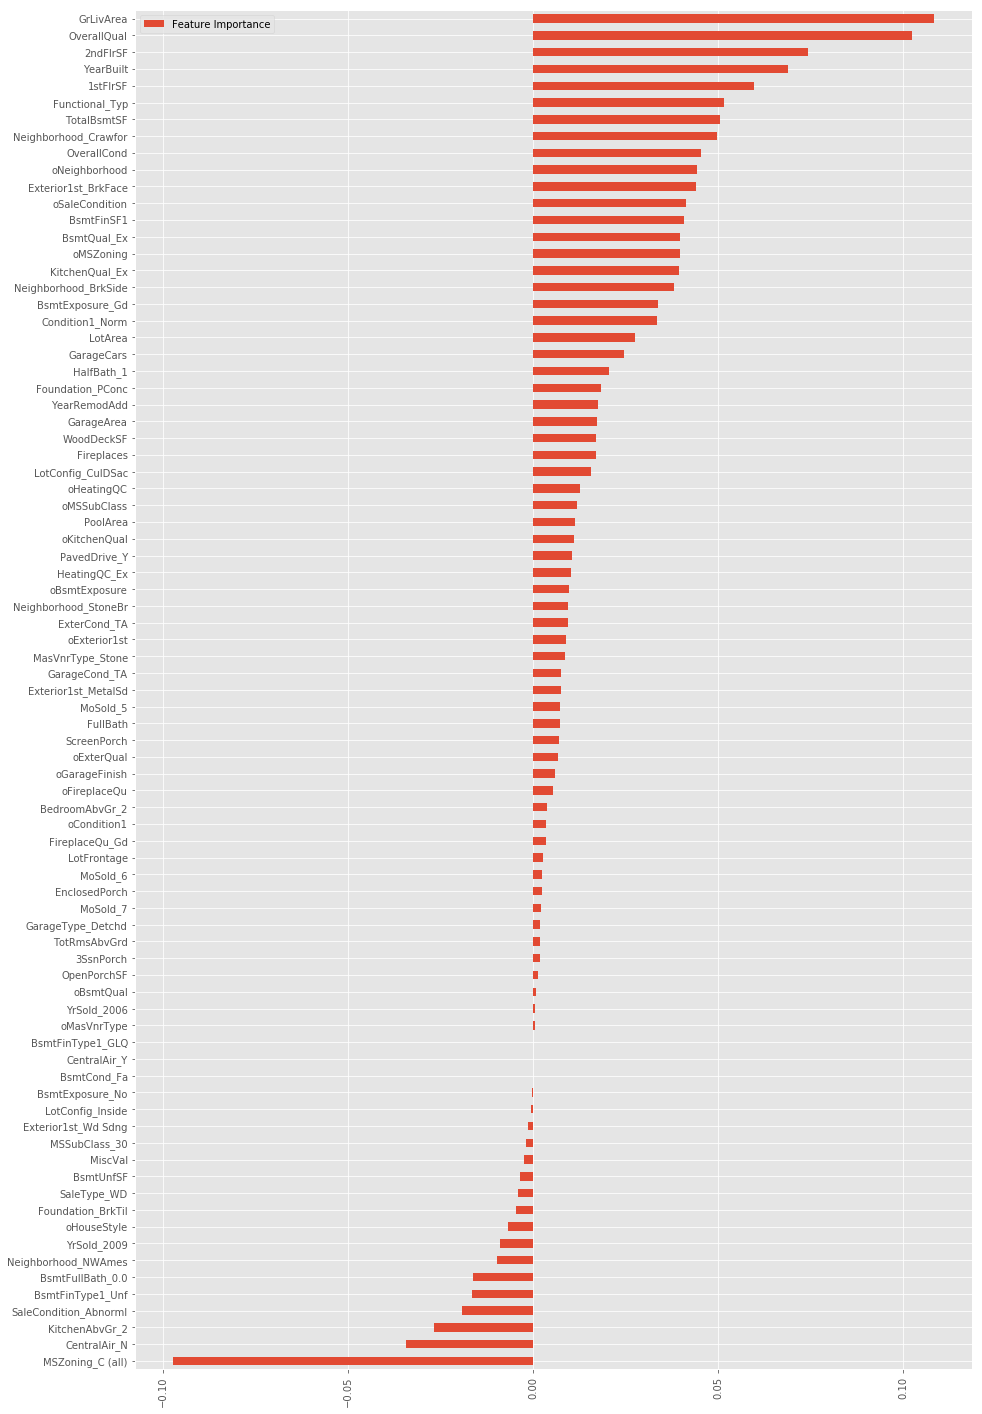

In [98]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [99]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
            X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
            X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
            X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
            X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
            X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
            
            X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
            X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
            X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
            X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]
            
           
            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

    
            return X

   
pipe = Pipeline([
    ('labenc', labelenc()),
    ('add_feature', add_feature(additional=2)),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

# PCA

In [100]:
full.oMSZoning

0       3
1       3
2       3
3       3
4       3
5       3
6       3
7       3
8       2
9       3
10      3
11      3
12      3
13      3
14      3
15      2
16      3
17      3
18      3
19      3
20      3
21      2
22      3
23      2
24      3
25      3
26      3
27      3
28      3
29      2
       ..
2887    2
2888    2
2889    1
2890    1
2891    1
2892    2
2893    2
2894    3
2895    3
2896    3
2897    3
2898    3
2899    3
2900    3
2901    3
2902    3
2903    2
2904    2
2905    3
2906    3
2907    2
2908    2
2909    3
2910    2
2911    2
2912    2
2913    2
2914    3
2915    3
2916    3
Name: oMSZoning, Length: 2917, dtype: int64

In [101]:
full_pipe = pipe.fit_transform(full)

full_pipe.shape

(2917, 426)

In [102]:
n_train=train.shape[0]
X = full_pipe[:n_train]
test_X = full_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit_transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

pca = PCA(n_components=410)

X_scaled=pca.fit_transform(X_scaled)
test_X_scaled = pca.transform(test_X_scaled)

X_scaled.shape, test_X_scaled.shape

((1458, 410), (1459, 410))

# Modeling & Evaluation

In [103]:
# define cross validation strategy
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

We choose 13 models and use 5-folds cross-calidation to evaluate these models.

Models include:

LinearRegression

Ridge

Lasso

Random Forrest

Gradient Boosting Tree

Support Vector Regression

Linear Support Vector Regression

ElasticNet

Stochastic Gradient Descent

BayesianRidge

KernelRidge

ExtraTreesRegressor

XgBoost

In [104]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y_log)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 1481755395.616654, 1472071817.0948
Ridge: 0.117521, 0.0091
Lasso: 0.121117, 0.0061
RF: 0.141040, 0.0068
GBR: 0.123829, 0.0080
SVR: 0.112749, 0.0048
LinSVR: 0.122787, 0.0093
Ela: 0.111394, 0.0060
SGD: 0.162099, 0.0109
Bay: 0.110557, 0.0060
Ker: 0.109235, 0.0055
Extra: 0.135784, 0.0047
Xgb: 0.125229, 0.0069


In [105]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [106]:
grid(Lasso()).grid_get(X_scaled,y_log,{'alpha': [0.0004,0.0005,0.0007,0.0009],'max_iter':[10000]})

{'alpha': 0.0005, 'max_iter': 10000} 0.11158348982903582
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.111694        0.001420
1  {'alpha': 0.0005, 'max_iter': 10000}         0.111583        0.001371
2  {'alpha': 0.0007, 'max_iter': 10000}         0.111882        0.001300
3  {'alpha': 0.0009, 'max_iter': 10000}         0.112266        0.001213


In [107]:
grid(Ridge()).grid_get(X_scaled,y_log,{'alpha':[35,40,45,50,55,60,65,70,80,90]})

{'alpha': 60} 0.11018139478921521
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.110353        0.001273
1  {'alpha': 40}         0.110284        0.001254
2  {'alpha': 45}         0.110237        0.001239
3  {'alpha': 50}         0.110206        0.001227
4  {'alpha': 55}         0.110189        0.001217
5  {'alpha': 60}         0.110181        0.001209
6  {'alpha': 65}         0.110183        0.001202
7  {'alpha': 70}         0.110192        0.001197
8  {'alpha': 80}         0.110227        0.001188
9  {'alpha': 90}         0.110281        0.001182


In [108]:
grid(SVR()).grid_get(X_scaled,y_log,{'C':[11,13,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})

{'C': 15, 'epsilon': 0.008, 'gamma': 0.0004, 'kernel': 'rbf'} 0.10814072514656946
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.108625   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.108269   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.108574   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.108235   
4   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.108538   
5   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.108172   
6   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.108512   
7   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.108149   
8   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.108471   
9   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.108141   
10  {'C': 15, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.108448   
11  {'C': 15, 'epsilon': 0.009

In [109]:
param_grid={'alpha':[0.2,0.3,0.4], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1]}
grid(KernelRidge()).grid_get(X_scaled,y_log,param_grid)

{'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'kernel': 'polynomial'} 0.10817091457232934
                                              params  mean_test_score  \
0  {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...         0.108171   
1  {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...         0.108396   
2  {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...         0.108316   
3  {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...         0.108183   
4  {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...         0.108688   
5  {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...         0.108216   

   std_test_score  
0        0.001216  
1        0.001253  
2        0.001193  
3        0.001217  
4        0.001185  
5        0.001197  


In [110]:
grid(ElasticNet()).grid_get(X_scaled,y_log,{'alpha':[0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3],'max_iter':[10000]})

{'alpha': 0.005, 'l1_ratio': 0.08, 'max_iter': 10000} 0.11139236512736352
                                              params  mean_test_score  \
0  {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter'...         0.114770   
1  {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter':...         0.114279   
2  {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter':...         0.112140   
3  {'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter':...         0.111465   
4  {'alpha': 0.004, 'l1_ratio': 0.1, 'max_iter': ...         0.111432   
5  {'alpha': 0.004, 'l1_ratio': 0.3, 'max_iter': ...         0.112686   
6  {'alpha': 0.005, 'l1_ratio': 0.08, 'max_iter':...         0.111392   
7  {'alpha': 0.005, 'l1_ratio': 0.1, 'max_iter': ...         0.111467   
8  {'alpha': 0.005, 'l1_ratio': 0.3, 'max_iter': ...         0.113078   

   std_test_score  
0        0.001962  
1        0.001920  
2        0.001618  
3        0.001414  
4        0.001352  
5        0.001169  
6        0.001337  
7        0.001305  
8        0.0011

In [111]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()

# assign weights based on their gridsearch score
w1 = 0.02
w2 = 0.2
w3 = 0.25
w4 = 0.3
w5 = 0.03
w6 = 0.2

weight_avg = AverageWeight(mod = [lasso,ridge,svr,ker,ela,bay],weight=[w1,w2,w3,w4,w5,w6])

score = rmse_cv(weight_avg,X_scaled,y_log)
print(score.mean())

0.10763633492087772


In [112]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [113]:
# must do imputer first, otherwise stacking won't work, and i don't know why.
a = Imputer().fit_transform(X_scaled)
b = Imputer().fit_transform(y_log.values.reshape(-1,1)).ravel()

stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)

score = rmse_cv(stack_model,a,b)
print(score.mean())

0.10638731801704804


# Submission

In [115]:
# This is the final model I use
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)

stack_model.fit(a,b)

stacking(meta_model=KernelRidge(alpha=0.2, coef0=0.8, degree=3, gamma=None, kernel='polynomial',
      kernel_params=None),
     mod=[Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=60, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=No...True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)])

In [116]:
pred = np.exp(stack_model.predict(test_X_scaled))

result=pd.DataFrame({'Id':test.Id, 'SalePrice':pred})
result.to_csv("submission.csv",index=False)